### Item-base Collaborative Filtering - Testing
This notebook is used to simulate the performance of the item-based collaborative filtering algorithm in a retrieval setting and in a prediction setting. 

#### Pre-requisites
- The model is trained and the index is created in the notebook `ItemCF Model & Index.ipynb`.
- The index is saved in the file `yelp_ItemCF.db` in the same directory as this notebook.

In [1]:
# import the python file from ../utilities.py
import sys
sys.path.append('../')
from utilities import *

In [2]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
data_files = ['business', 'categories', 'review', 'user']

# Load data into a dictionary
yelp_data = load_data_from_db(db_folder, data_files)

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.
Loaded 229447 rows from user table.


In [3]:
df_business = yelp_data["business"]
df_review = yelp_data["review"]
df_user = yelp_data["user"]

user_mapping, business_mapping, user_business = get_user_business(df_business, df_review)

In [15]:
# count the number of reviews for each user
df = df_review.groupby('user_id').size().reset_index(name='review_count')

In [19]:
df.sort_values(by='review_count', ascending=False, inplace=True)
df['review_count'].median()

np.float64(2.0)

In [4]:
df_user = df_user[["user_id", "review_count"]].sort_values(by="review_count", ascending=False).reset_index(drop=True)
df_user

,user_id,review_count
0,Hi10sGSZNxQH3NLyWSZ1oA,17473
1,hWDybu_KvYLSdEFzGrniTw,16567
2,P5bUL3Engv-2z6kKohB6qQ,9941
3,nmdkHL2JKFx55T3nq5VziA,8363
4,bQCHF5rn5lMI9c5kEwCaNA,8354
...,...,...
229442,G1Cr_4i_pJJM4cfGjSHnTw,1
229443,Vw71dwITV_J0ANLenTaL7g,1
229444,VuhY3tqUjMsFoV5ERRT58g,0
229445,qXHJa8Tf7Ef_wieJLIatxw,0


In [26]:
# split the data into training and test sets
train_data, test_data = train_test_split(user_business, test_size=0.2, random_state=42)

In [27]:
# balance the test data, comment this line to use the original test data
test_data = balance_test_data(test_data)

# group the test data by user_id and get the business_id
test_data_grouped = test_data.groupby('user_id')['business_id'].apply(list).reset_index()

Number of positive reviews: 136473
Number of negative reviews: 59624
Total number of reviews: 197147
Ratio of positive to negative reviews: 2.29
Number of positive reviews: 59624
Number of negative reviews: 59624
Total number of reviews: 119248
Ratio of positive to negative reviews: 1.00


In [28]:
# Connect to the SQLite database
db_path = './yelp_ItemCF.db'
conn = sqlite3.connect(db_path)

### Retrieval Evaluation

In [29]:
retrieval_recommendations = simulate_recommendations(test_data_grouped, user_mapping, business_mapping, conn, k=300, num_users=1000)

In [17]:
true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)

evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)

In [18]:
print("Testing Data Statistics")
display(background_stats)

print("Evaluation Metrics")
display(evaluation_metric)

print("Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1045,1083,2128,0.491071


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5324,0.5527,0.2507,0.345,0.2815,0.0686


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,262,871,212,783


### Split user by review count

In [51]:
# Categorize users by review count
# threshold = df_user['review_count'].median()
threshold = 40.0
df_user['review_group'] = np.where(df_user['review_count'] >= threshold, 'high_review', 'low_review')

In [52]:
# Merge review group information with test_data_grouped
test_data_grouped_1 = test_data_grouped.merge(df_user[['user_id', 'review_group']], on='user_id', how='left')

# Initialize dictionaries to store results for each group
results = {'high_review': {}, 'low_review': {}}


In [53]:
test_data_grouped_1['review_group'].value_counts()

review_group
low_review     29911
high_review    27393
Name: count, dtype: int64

In [54]:
# Evaluate for each group
for group in ['high_review', 'low_review']:
    # Filter test data and recommendations for the current group
    group_test_data_grouped = test_data_grouped_1[test_data_grouped_1['review_group'] == group]
    group_user_ids = group_test_data_grouped['user_id']
    
    # Filter recommendations for users in this group
    group_recommendations = {uid: rec for uid, rec in retrieval_recommendations.items() if uid in group_user_ids.values}
    group_test_data = test_data[test_data['user_id'].isin(group_user_ids)]

    if len(group_test_data_grouped) == 0 or len(group_recommendations) == 0:
        print(f"No users or recommendations in {group} group for evaluation.")
        results[group] = {
            'evaluation_metric': pd.DataFrame(),
            'confusion_matrix': pd.DataFrame(),
            'background_stats': pd.DataFrame()
        }
        continue

    # Compute retrieval metrics
    true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(
        group_recommendations, group_test_data, group_test_data_grouped
    )

    # Compute evaluation metrics
    evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(
        true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks
    )

    # Store results
    results[group] = {
        'evaluation_metric': evaluation_metric,
        'confusion_matrix': confusion_matrix,
        'background_stats': background_stats
    }


In [55]:
# Display results
for group in results:
    print(f"\nResults for {group.replace('_', ' ').title()} Group")
    print("Testing Data Statistics")
    display(results[group].get('background_stats', pd.DataFrame()))
    print("Evaluation Metrics")
    display(results[group].get('evaluation_metric', pd.DataFrame()))
    print("Confusion Matrix")
    display(results[group].get('confusion_matrix', pd.DataFrame()))


Results for High Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,749,741,1490,0.502685


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5268,0.5576,0.2844,0.3767,0.3153,0.0387


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,213,572,169,536



Results for Low Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,296,342,638,0.46395


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5455,0.5326,0.1655,0.2526,0.192,0.1435


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,49,299,43,247


threshold = 3

In [33]:
# Display results
for group in results:
    print(f"\nResults for {group.replace('_', ' ').title()} Group")
    print("Testing Data Statistics")
    display(results[group].get('background_stats', pd.DataFrame()))
    print("Evaluation Metrics")
    display(results[group].get('evaluation_metric', pd.DataFrame()))
    print("Confusion Matrix")
    display(results[group].get('confusion_matrix', pd.DataFrame()))


Results for High Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1031,1058,2089,0.493538


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5309,0.5541,0.2532,0.3475,0.284,0.0642


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,261,848,210,770



Results for Low Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,14,25,39,0.358974


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.6154,0.3333,0.0714,0.1176,0.0847,0.5152


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,1,23,2,13


threshold = 11

In [13]:
# Display results
for group in results:
    print(f"\nResults for {group.replace('_', ' ').title()} Group")
    print("Testing Data Statistics")
    display(results[group].get('background_stats', pd.DataFrame()))
    print("Evaluation Metrics")
    display(results[group].get('evaluation_metric', pd.DataFrame()))
    print("Confusion Matrix")
    display(results[group].get('confusion_matrix', pd.DataFrame()))


Results for High Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,955,959,1914,0.498955


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5277,0.556,0.2649,0.3589,0.2959,0.0551


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,253,757,202,702



Results for Low Review Group
Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,90,124,214,0.420561


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5748,0.4737,0.1,0.1651,0.1187,0.273


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,9,114,10,81


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the evaluation metrics for both groups
high_review_metrics = {
    'Accuracy': 0.5268,
    'Precision': 0.5576,
    'Recall': 0.2844,
    'F1 Score': 0.3767,
    'F-beta Score': 0.3153,
    'Mean Reciprocal Rank': 0.0387
}

low_review_metrics = {
    'Accuracy': 0.5455,
    'Precision': 0.5326,
    'Recall': 0.1655,
    'F1 Score': 0.2526,
    'F-beta Score': 0.1920,
    'Mean Reciprocal Rank': 0.1435
}

# Create DataFrames for each group
df_high = pd.DataFrame([high_review_metrics], index=['High Review Group'])
df_low = pd.DataFrame([low_review_metrics], index=['Low Review Group'])

# Combine into a single DataFrame
df_metrics = pd.concat([df_high, df_low])

# Convert to long format for plotting
df_long = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_long = df_long.rename(columns={'index': 'Group'})


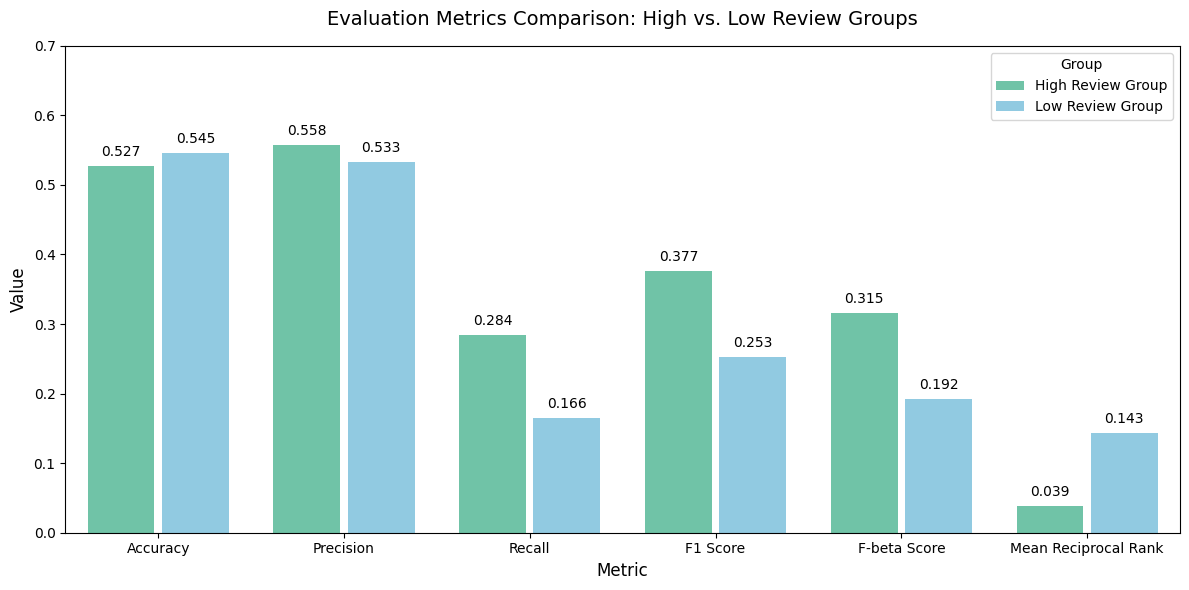

In [93]:
# Set up the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Metric', 
    y='Value', 
    hue='Group', 
    data=df_long, 
    palette=['#66cdaa', '#87ceeb'],  # High Review: medium aquamarine, Low Review: sky blue
    dodge=True,  # Ensure bars are separated
    width=0.8,  # Adjust bar width to create gap (0.4 per bar, total 0.8 per metric)
    saturation=0.8,
    gap=0.1  # Adjust gap between bars
)
# Add value labels on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    if height > 0.001:  # Only label positive heights
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Center of the bar
            height + 0.01,  # Slightly above the bar
            f'{height:.3f}',  # Value rounded to 4 decimal places
            ha='center', va='bottom', fontsize=10
        )

# Customize the plot
plt.title('Evaluation Metrics Comparison: High vs. Low Review Groups', fontsize=14, pad=15)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.ylim(0, 0.7)  # Adjust y-axis to accommodate metric range
plt.legend(title='Group', fontsize=10)
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display and save the plot
plt.savefig('evaluation_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Prediction Evaluation

In [ ]:
predicted_labels, actual_labels, positive_count, negative_count, null_count, unrated_count = predict_recommendations(test_data, test_data_grouped, business_mapping, conn)

prediction_lst = [positive_count, negative_count, unrated_count]
evaluation_metric, confusion_matrix, background_stats = compute_prediction_evaluation(actual_labels, predicted_labels, prediction_lst)

In [ ]:
prediction_lst = [positive_count, negative_count, unrated_count]
evaluation_metric, confusion_matrix, background_stats = compute_prediction_evaluation(actual_labels, predicted_labels, prediction_lst, 2)

In [ ]:
print("Testing Data Statistics")
display(background_stats)


# drop the MRR column if it exists
if 'Mean Reciprocal Rank' in evaluation_metric.columns:
    evaluation_metric.drop(columns=['Mean Reciprocal Rank'], inplace=True)
    

print("Evaluation Metrics")
display(evaluation_metric)

print("Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1043,1085,2128,0.490132


Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Unrated Count
0,0.6005,0.612,0.264606,0.369468,0.298494,0.434211


Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,276,447,175,306


In [15]:
conn.close()

### Adding Retrieval Result to the db

In [10]:
db_path = '../Result_Evaluation/Retrieval.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create a lookup for fast access to star ratings from the test data:
# This dictionary maps (user_id, business_id) to the star rating.
test_data_lookup = {
    (row['user_id'], row['business_id']): row['stars_review']
    for _, row in test_data.iterrows()
}

# Prepare bulk records for insertion into SQLite.
# Format: (model, user_id, business_id, real_label)
# Here we assume a positive review (real_label = 1) if stars >= 4, else negative (real_label = 0).
bulk_records = []
model_name = "ItemCF"  # You can change this if needed

for user_id, recommended_businesses in retrieval_recommendations.items():
    for business_id in recommended_businesses[0]:
        # Check the star rating from the test data lookup
        star_rating = test_data_lookup.get((user_id, business_id))
        # Define the real label: 1 if rating is available and >= 4, otherwise 0.
        real_label = 1 if star_rating is not None and star_rating >= 4 else 0
        if real_label == 1:
            print(f"User {user_id} was recommended business {business_id} with a positive rating of {star_rating}.")
        bulk_records.append((model_name, user_id, business_id, real_label))

# Example: Now perform a bulk insert using SQLite's executemany.
# Make sure your 'recommendations' table has a UNIQUE constraint on (model, user_id, business_id) if needed.
cursor.executemany("""
    INSERT OR IGNORE INTO recommendations (model, user_id, business_id, real_label)
    VALUES (?, ?, ?, ?)
""", bulk_records)
conn.commit()

# Close the connection
conn.close()

User --Vu3Gux9nPnLcG9yO_HxA was recommended business WwPdWaLYBRz7By915qlXRg with a positive rating of 5.0.
User --XwFm4qERD6J5SX0JAsbg was recommended business MbNcVhRqpNPcvgFzWgaxSQ with a positive rating of 5.0.
User --u09WAjW741FdfkJXxNmg was recommended business 71U7MxQEhwitJOm4CQpRwQ with a positive rating of 4.0.
User -0KrCHEsOcjJ6N4k_k1A9A was recommended business KdAWjL9MKjpJzEeI902qBA with a positive rating of 4.0.
User -0MIp6WKJ8QvGnYZQ5ETyg was recommended business j-qtdD55OLfSqfsWuQTDJg with a positive rating of 5.0.
User -13RX4Gy_F-zoLIenWAo-w was recommended business dGeXdSMah56gEHwZNaRQKA with a positive rating of 5.0.
User -2cKJFFNJ9XVyWBt62mWvA was recommended business NbOWECn3ilz4gWL6dm5P6g with a positive rating of 5.0.
User -3Dzhux7DmA0Rj6P8PtQNA was recommended business EaqASiPkxV9OUkvsAp4ODg with a positive rating of 5.0.
User -3s52C4zL_DHRK0ULG6qtg was recommended business 0QYWhij_YZ7Lyk9F6213Sg with a positive rating of 5.0.
User -3s52C4zL_DHRK0ULG6qtg was recom